# Class 4 analysis: the undersampled class

## Imports and data loading

In [1]:
import sys
sys.path.append('..')
import AugmentationHelper

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
# Setting seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
data = np.load("../data/class4_samples.npz")

training_set = data.get("training_set")
test_set = data.get("test_set")

# Split training set into input images and masks
input_images = training_set[:, 0, :, :]
output_masks = training_set[:, 1, :, :]

print("Input images shape:", input_images.shape)
print("Output masks shape:", output_masks.shape)

n_samples = input_images.shape[0]

Input images shape: (63, 64, 128)
Output masks shape: (63, 64, 128)


In [4]:
colors = ["black", "red", "blue", "green", "yellow"]
bounds = [0, 1, 2, 3, 4, 5]  # Bounds correspond to the intervals between numbers.
norm = mpl.colors.BoundaryNorm(bounds, len(colors))

# Create the colormap
colormap = mpl.colors.ListedColormap(colors)

There are some samples that barely have yellow in them, let's delete them

In [5]:
threshold = 60  # minimum number of yellow pixels in a mask

not_yellow = []
count = []
for i, mask in enumerate(output_masks):
    yellow_count = np.sum(mask == 4)
    if yellow_count <= threshold:
        not_yellow.append(i)
        count.append(f"Yellow pixels count: {yellow_count}")

len(not_yellow)

15

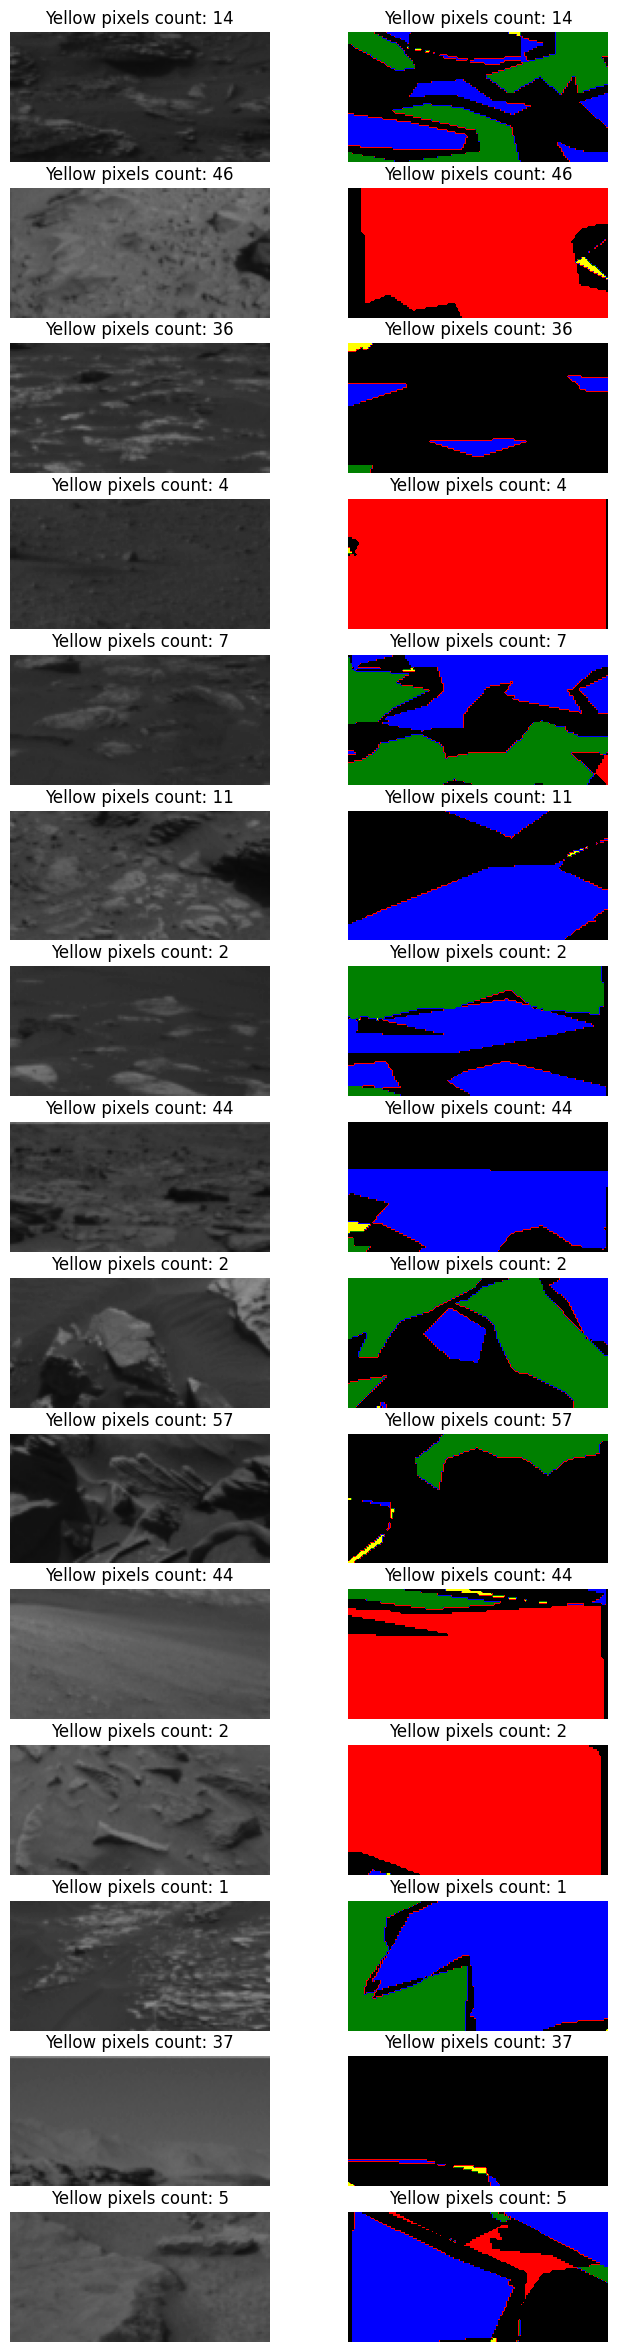

In [6]:
AugmentationHelper.plot_images_and_masks(input_images[not_yellow], output_masks[not_yellow],titles=count, figsize=(8,30))

In [7]:
# delete not enough yellow pictures
images = np.delete(input_images, not_yellow, axis=0)
labels = np.delete(output_masks, not_yellow, axis=0)

images.shape, labels.shape

((48, 64, 128), (48, 64, 128))

## Cropping Big Rock (class 4) -> yellow zones and resizing

(<Axes: title={'center': 'Zoomed Mask'}>,
 Text(0.5, 1.0, 'Zoomed Mask'),
 (-0.5, 127.5, 63.5, -0.5))

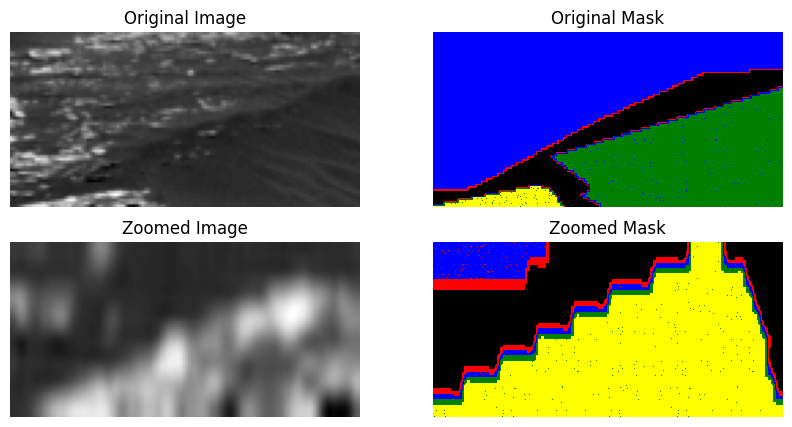

In [8]:
# Apply augmentation
import cv2
zoomed_image, zoomed_mask = AugmentationHelper.resize_crop(images[0], labels[0],cv2.INTER_CUBIC)

# Show augmented image and mask
plt.figure(figsize=(10, 5))
plt.subplot(221), plt.imshow(input_images[0], cmap='gray'), plt.title('Original Image'), plt.axis('off')
plt.subplot(222), plt.imshow(output_masks[0], cmap=colormap, norm=norm), plt.title('Original Mask'), plt.axis('off')
plt.subplot(223), plt.imshow(zoomed_image, cmap='gray'), plt.title('Zoomed Image'), plt.axis('off')
plt.subplot(224), plt.imshow(zoomed_mask, cmap=colormap, norm=norm), plt.title('Zoomed Mask'), plt.axis('off')

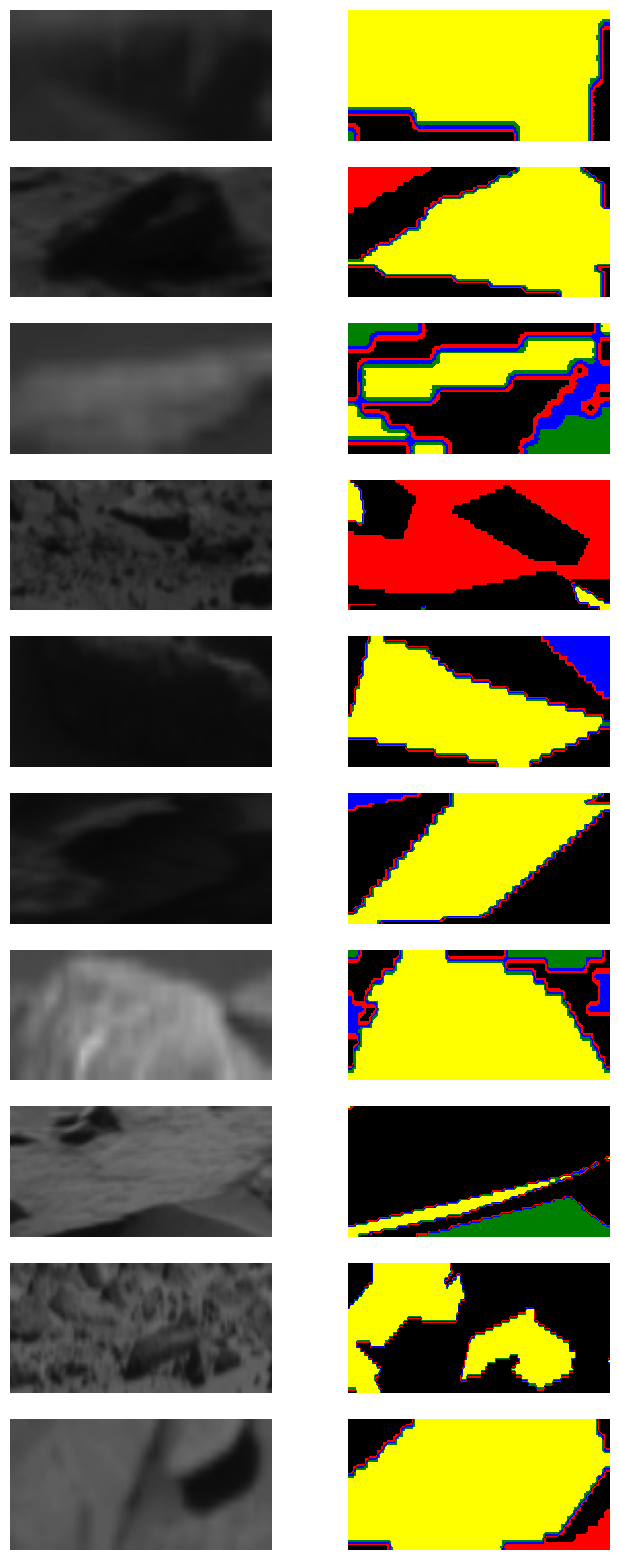

In [9]:
# apply cropping and zooming to all images
zoomed_images = []
zoomed_masks = []
for i in range(images.shape[0]):
    im, mk = AugmentationHelper.resize_crop(images[i], labels[i])
    if (im is not False and mk is not False):
        zoomed_images.append(im)
        zoomed_masks.append(mk)

zoomed_images = np.array(zoomed_images)
zoomed_masks = np.array(zoomed_masks)

# show 5 random augmented images and masks
random_indices = np.random.choice(len(zoomed_images), size=10, replace=False)
AugmentationHelper.plot_images_and_masks(zoomed_images[random_indices], zoomed_masks[random_indices], figsize=(8, 20))

In [10]:
# Concat original and augmented images and masks
all_images = np.concatenate((images, zoomed_images))
all_masks = np.concatenate((labels, zoomed_masks))

all_images.shape, all_masks.shape

((96, 64, 128), (96, 64, 128))

## Augmentation with AugmentationHelper

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_masks))
print(f"Original samples: {len(dataset)}")

aug_geometric = dataset.map(AugmentationHelper.map_geometric_transform, num_parallel_calls=tf.data.AUTOTUNE)
aug_intensity = dataset.map(AugmentationHelper.map_intensity_transform, num_parallel_calls=tf.data.AUTOTUNE)
aug_total = dataset.map(AugmentationHelper.map_total_transform, num_parallel_calls=tf.data.AUTOTUNE)
dataset_aug = aug_geometric.concatenate(aug_intensity).concatenate(aug_total)
dataset = dataset.concatenate(dataset_aug)
print(f"New samples after first aug: {len(dataset_aug)}")

## Apply additional geometric transformations to all new dataset
new_aug_geometric = dataset.map(AugmentationHelper.map_geometric_transform, num_parallel_calls=tf.data.AUTOTUNE)
dataset_aug = dataset_aug.concatenate(new_aug_geometric)

print(f"New samples after second aug: {len(dataset_aug)}")

Original samples: 96
New samples after first aug: 288
New samples after second aug: 672


In [12]:
aug_images, aug_labels = AugmentationHelper.dataset_to_list(dataset_aug)
aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)
aug_images.shape, aug_labels.shape

((672, 64, 128), (672, 64, 128))

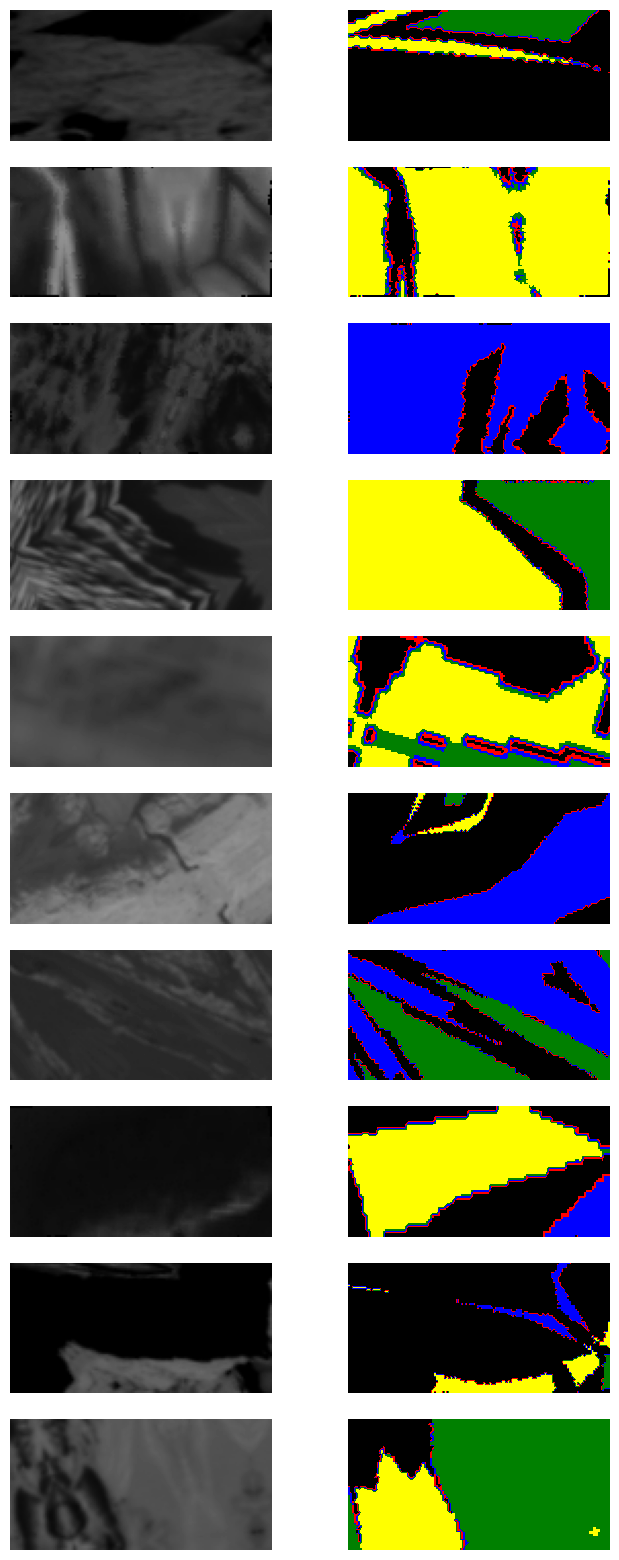

In [13]:
# show 5 random samples
random_indices = np.random.choice(aug_images.shape[0], size=10, replace=False)
AugmentationHelper.plot_images_and_masks(aug_images[random_indices], aug_labels[random_indices], figsize=(8, 20))

## Save data

In [14]:
# Concat original and augmented images and masks
all_images = np.concatenate((all_images, aug_images))
all_masks = np.concatenate((all_masks, aug_labels))

all_images.shape, all_masks.shape

((768, 64, 128), (768, 64, 128))

In [16]:
# Combine cleaned input images and masks into the same format as training_set
training_set_clean = np.stack((all_images, all_masks), axis=1)

# Save the cleaned data in the same format
output_path = "../data/class4_augmented.npz"
np.savez(output_path, training_set=training_set_clean, test_set=test_set)

In [22]:
# Combine only new generated samples with original dataset
# (Excluding original samples, so we dont have duplicates)
# Combining: zoomed_images,zoomed_masks, aug_images, aug_labels

orig_data = np.load("../data/ds_no_aliens_no_95bg.npz")

# Extract training_set and test_set
training_set = orig_data.get("training_set")
test_set = orig_data.get("test_set")

orig_input_images = training_set[:, 0, :, :]
orig_output_masks = training_set[:, 1, :, :]

# Concat original and zoomed images and masks
full_images = np.concatenate((orig_input_images, zoomed_images))
full_masks = np.concatenate((orig_output_masks, zoomed_masks))

print(full_images.shape, full_masks.shape)

# Concat previous and augmented images and masks
full_images = np.concatenate((full_images, aug_images))
full_masks = np.concatenate((full_masks, aug_labels))

print(full_images.shape, full_masks.shape)

(2431, 64, 128) (2431, 64, 128)
(3103, 64, 128) (3103, 64, 128)


In [23]:
# Save full dataset
training_set_full = np.stack((full_images, full_masks), axis=1)

# Save the cleaned data in the same format
output_path = "../data/ds_no_aliens_no_95bg_aug_class4.npz"
np.savez(output_path, training_set=training_set_full, test_set=test_set)

## Final pixel count

In [27]:
# Step 1: Flatten the masks
flattened_masks = full_masks.flatten()

# Step 2: Count pixels for each class
class_pixel_counts = np.unique(flattened_masks, return_counts=True)[1]

# Ignore class 0: Background
print(f"Amount of background pixels (ignored): {class_pixel_counts[0]:,}")
class_pixel_counts[0] = 0

# Step 3: Calculate class proportions
total_pixels = sum(class_pixel_counts)
class_proportions = class_pixel_counts / total_pixels

# Display results
formatted_counts = [f"{count:,}" for count in class_pixel_counts]
print("Class Pixel Counts:", formatted_counts)
print("Class Proportions:", class_proportions)

Amount of background pixels (ignored): 6,746,984
Class Pixel Counts: ['0', '7,413,970', '5,285,358', '4,558,115', '1,415,349']
Class Proportions: [0.         0.39704668 0.2830513  0.24410463 0.0757974 ]


Still need to augment more 7% class 1 